In [1]:
# The <Noname> simulator's goal is to provide the fast and cheap testing ground
# for the autoscaling policies/mechanism used in interactive transaction-based
# applications deployed in the cloud using the containers.
# The following models constitute the simulator:
# 1) application model - determines the logical structure of the application, i.e.
# which services communicate, how much time is required to process particular requests,
# how large are the buffers for storing the queries awaiting the processing. Overall,
# the application is represented as a general networked queueing model.
# The components of the model:
# - static -> the connections forming the logic of the application + processing times
# - dynamic -> the amount of instances of the application services (containers)
# 2) workload/load model - determines the load generated by the users of the application,
# i.e. requests times, distribution of the requests in time (e.g. diurnal, seasonal),
# the composition of the workload mixture (i.e. distribution of requests in terms of
# required processing times, e.g. 80% small reqs, 20% large ones)
# 3) scaling model - determines the scaling behaviour of the application, i.e. how
# much time might be required to take/conduct the scaling decision.
# 4) service level model - determines the expected level(s) of the service provided by
# the application as a whole, e.g. in terms of the response times or distirbutions thereof,
# in terms of services availability.
# 5) platform model (hardware/ virtual machines) - models the most relevant characteristics
# of the platform in terms of performance, e.g. the number of hw threads/cores that might
# be needed to known to accomodate the demands of the logical service instance in terms
# of threads. Note: we are not solving the placement problem! This is something done
# by the cloud services provider.
# 6) cost model - models the cost of the platform resource used during the simulation.
# 7) failure/availability model - determines the failure mode of the platform/app, s.t.
# the scaling procedure should be able to compensate for the unpredictably failing nodes.
# 8) performance interference/tenancy model - determines, how much CPU stealing can happen
# on the platform shared between the simulated application and some other application
# co-deployed in the cloud on the same infra.
# 9) scaling policy - provides a scaling plan that is executed by the simulation,
# follows a particular instance or the combination thereof of scaling policies.
# 10) network model - determines link latencies and bandwidth

In [43]:
import uuid
import random
# Assumptions:
# 1) Requests chains separation -> requests made by the user do not depend on other
# requests by the user, although they can generate multiple other requests.
# 2) Simulation step is smaller or equal to the processing duration at the smallest
# component.

# simulation at each clock cycle:
# 1) generates requests and tries to put into the system
# 2) iterates over the reqs in the system and updates their stats
# 3) according to the scaling policy may update the dyn config of the app

# reqs_types_ratios = {'auth': 0.8, 'buy': 0.2}
class WorkloadModel:
    def __init__(self,
                 reqs_types_ratios,
                 sampling_ms = 0):
        
        self.reqs_types_ratios = reqs_types_ratios
        self.workload = {}
        
    def generate_requests(self, timestamp = 0):
        gen_reqs = []
        
        num_reqs = random.randint(0, 10)
        for req_type, ratio in self.reqs_types_ratios.items():
            req_types_reqs_num = int(ratio * num_reqs)
            for i in range(req_types_reqs_num):
                req = Request(req_type)
                gen_reqs.append(req)
                
        return gen_reqs
            
        


# application model incorps params of the requests since it depends on the
# structure and the processing logic of the app, whereas the workload model
# quantifies the amount and the distribution of the requests in time/volume
# so, propagation chain of the request goes into the app model

# The request can be fanned out if needed -> multiple request with the
# same ID are created then.
class Request:
    def __init__(self,
                 request_type,
                 request_id = None):
        # Static state
        self.request_type = request_type
        if request_id is None:
            self.request_id = uuid.uuid1()
        else:
            self.request_id = request_id
        
        # Dynamic state
        self.processing_left_ms = 0
        self.cumulative_time_ms = 0
        self.done = False
        self.upstream = True
        
    def set_done(self):
        self.done = True
        
    def set_downstream(self):
        self.upstream = False
    
# Example inputs:
# request_type = "auth"
# processing_times = {"frontend": [10, 0], "appserver": [50, 20], "db": [10,0], "dba": [20,0]}
# in array of processing times: [<upstream>, <downstream>]
# Static structure that defines how the requests are processed
class RequestProcessingInfo:
    def __init__(self,
                 request_type,
                 entry_service,
                 processing_times):
        
        self.request_type = request_type
        self.entry_service = entry_service
        self.processing_times = processing_times

class Queue:
    # combines link and the queue
    # link has a property of rejecting the msg
    # TODO: think of implementing other disciplines, not just FIFO
    def __init__(self,
                 capacity_by_request_type):
        
        self.capacity_by_request_type = capacity_by_request_type
        self.requests = []
        
    def enqueue(self, req):
        self.requests.append(req)
        
    def pop(self):
        return self.requests.pop()
    
    def size(self):
        return len(self.requests)
    
    def add_cumulative_time(self, delta):
        for req in self.requests:
            req.cumulative_time_ms += delta
        
class Service:
    def __init__(self,
                 queue_capacity_by_request_type,
                 threads_per_instance,
                 simulation_step_ms,
                 instances = 1):
        
        self.upstream_queue = Queue(queue_capacity_by_request_type)
        self.downstream_queue = Queue(queue_capacity_by_request_type)
        self.replies = [] # Replies that we got from the upstream services
        
        self.threads_per_instance = threads_per_instance
        # TODO: should replace with the real platform info below!
        self.hw_threads_per_instance = 4
        self.instances = instances
        self.simulation_step_ms = simulation_step_ms
        
        # requests that are currently in simultaneous processing
        self.in_processing_simultaneous = []
        # requests that are processed in this step, they can proceed
        self.out = []
        
    def add_request(self, req):
        # decide where to put the request
        if req.upstream:
            self.upstream_queue.enqueue(req)
        else:
            self.downstream_queue.enqueue(req)
        
    def step(self):
        processing_time_left_at_step = self.simulation_step_ms
        
        while(processing_time_left_at_step > 0):
            if (self.downstream_queue.size() == 0) and (self.upstream_queue.size() == 0):
                processing_time_left_at_step = 0
                continue
                
            if len(self.in_processing_simultaneous) > 0:
                # Find minimal leftover duration, subtract it,
                # and propagate the request
                min_leftover_time = min([req.processing_left_ms for req in self.in_processing_simultaneous])
                min_time_to_subtract = min(min_leftover_time, processing_time_left_at_step)
                new_in_processing_simultaneous = []
                
                for req in self.in_processing_simultaneous:
                    new_time_left = req.processing_left_ms - min_time_to_subtract
                    if new_time_left > 0:
                        req.processing_left_ms = new_time_left
                        new_in_processing_simultaneous.append(req)
                    else:
                        # Request is put into the out buffer to be
                        # processed further according to the app structure
                        req.processing_left_ms = 0
                        req.cumulative_time_ms += min_time_to_subtract  
                        self.out.append(req)
                
                processing_time_left_at_step -= min_time_to_subtract
                self.in_processing_simultaneous = new_in_processing_simultaneous
                
            spare_capacity = int(self.instances * self.hw_threads_per_instance - len(self.in_processing_simultaneous) * self.threads_per_instance)
            # Assumption: first we try to process the downstream reqs to
            # provide the response faster, but overall it is application-dependent
            while ((self.downstream_queue.size() > 0) or (self.upstream_queue.size() > 0)) and (spare_capacity > 0):
                # TODO: consider fan-in
                if self.downstream_queue.size() > 0:
                    req = self.downstream_queue.pop()
                    self.in_processing_simultaneous.append(req)
                    spare_capacity = int(self.instances * self.hw_threads_per_instance - len(self.in_processing_simultaneous) * self.threads_per_instance)
            
                if self.upstream_queue.size() > 0:
                    req = self.upstream_queue.pop()
                    self.in_processing_simultaneous.append(req)
                    spare_capacity = int(self.instances * self.hw_threads_per_instance - len(self.in_processing_simultaneous) * self.threads_per_instance)
            
        # Increase the cumulative time for all the reqs left in the queues waiting
        self.upstream_queue.add_cumulative_time(self.simulation_step_ms)
        self.downstream_queue.add_cumulative_time(self.simulation_step_ms)


        
# Services: {'frontend': service1, 'appserver': service2, 'db': service3}
# Structure: {'frontend': ['appserver'], 'appserver': ['db'], 'db': None}
# Starting points: ['frontend']
# reqs_processing_infos: {'auth': req_proc_info1} -> also store the reverse path!
class ApplicationModel:
    def __init__(self,
                 services,
                 structure,
                 reqs_processing_infos,
                 filename = None):
        # TODO: alternative from file
        self.services = services
        self.structure = structure
        self.reqs_processing_infos = reqs_processing_infos
        self.new_requests = []
        self.response_times_by_request = {}
        
    def step(self):
        if len(self.new_requests) > 0:
            for req in self.new_requests:
                entry_service = self.reqs_processing_infos[req.request_type].entry_service
                req.processing_left_ms = self.reqs_processing_infos[req.request_type].processing_times[entry_service][1]
                services[entry_service].add_request(req)
                
            self.new_requests = []
        
        # Proceed through the services // fan-in merge and fan-out copying
        # is done in the app logic since it knows the structure and times
        # IMPORTANT: the simulation step should be small for the following
        # processing to work correctly ~5-10 ms.
        for service_name, service in services.items():
            service.step()
            
            while len(service.out) > 0:
                req = service.out.pop()
                req_info = self.reqs_processing_infos[req.request_type]
                
                if req.upstream:
                    next_services_names = self.structure[service_name]['next']
                    if not next_services_names is None:
                        for next_service_name in next_services_names:
                            if next_service_name in req_info.processing_times:
                                req_cpy = req
                                req_cpy.processing_left_ms = req_info.processing_times[next_service_name][0]
                                self.services[next_service_name].add_request(req_cpy)
                    else:
                        # Sending response
                        req.upstream = False
                        
                if not req.upstream:
                    prev_services_names = self.structure[service_name]['prev']
                    if not prev_services_names is None:
                        for prev_service_name in prev_services_names:
                            if prev_service_name in req_info.processing_times:
                                req_cpy = req
                                req_cpy.processing_left_ms = req_info.processing_times[prev_service_name][1]
                                self.services[prev_service_name].add_request(req_cpy)
                    else:
                        # Response received by the user
                        if req.request_type in self.response_times_by_request:
                            self.response_times_by_request[req.request_type].append(req.cumulative_time_ms)
                        else:
                            self.response_times_by_request[req.request_type] = [req.cumulative_time_ms]
            
        #for req_type, req_processing_info in self.reqs_processing_infos.items():
        #    cur_service_lbl = req_processing_info.entry_service
        #    prev_service_lbl = None
        #   
        #    while not cur_service_lbl is None:
        #        cur_service = self.services[cur_service_lbl]
        #        cur_service.step()
        #        while len(cur_service.out[req_type]) > 0:
        #            req = cur_service.out[req_type].pop()
        #            if req.upstream:
        #                
        #            next_service_lbl
        #           # determine link and put there
                
        # processing_times = {"frontend": [10, 0], "appserver": [50, 20], "db": [10,0], "dba": [20,0]}
        # Services: {'frontend': service1, 'appserver': service2, 'db': service3}
        # Structure: {'frontend': {'next': ['appserver'], 'prev': None},
        #             'appserver': {'next': ['db'], 'prev': ['frontend']},
        #             'db': {'next': None, 'prev': ['appserver']}}
    def enter_requests(self, new_requests):
        self.new_requests = new_requests



In [50]:
class Simulation:
    def __init__(self,
                 workload_model,
                 application_model,
                 time_to_simulate_days = 0.01,
                 simulation_step_ms = 10):
        
        # add starting time
        self.simulation_step_ms = simulation_step_ms
        self.time_to_simulate_ms = int(time_to_simulate_days * 24 * 60 * 60 * 1000)
        self.cur_simulation_time_ms = 0
        self.workload_model = workload_model
        self.application_model = application_model
        self.sim_round = 0
        
    def _step(self):
        # 1. Generate requests from the workload model, add them to the app model
        new_requests = self.workload_model.generate_requests()
        self.application_model.enter_requests(new_requests)
        self.application_model.step()
        
        # 3. Collect metrics (proc. times etc.)
        
    def start(self):
        while(self.cur_simulation_time_ms <= self.time_to_simulate_ms):
            self.cur_simulation_time_ms += self.simulation_step_ms
            self._step()
            self.sim_round += 1
            if self.sim_round % 1000 == 0:
                left_to_simulate_ms = self.time_to_simulate_ms - self.cur_simulation_time_ms
                print('Time left: {} min'.format(int(left_to_simulate_ms / (1000 * 60))))
            # TODO: print leftover steps?

In [51]:
wlm_test = WorkloadModel({'auth': 0.8, 'buy': 0.2})

frontend = Service(queue_capacity_by_request_type = {'auth': 20, 'buy': 10},
                   threads_per_instance = 2,
                   simulation_step_ms = 10,
                   instances = 1)

appserver = Service(queue_capacity_by_request_type = {'auth': 20, 'buy': 10},
                   threads_per_instance = 4,
                   simulation_step_ms = 10,
                   instances = 1)

db = Service(queue_capacity_by_request_type = {'auth': 20, 'buy': 10},
             threads_per_instance = 2,
             simulation_step_ms = 10,
             instances = 1)

services = {'frontend': frontend, 'appserver': appserver, 'db': db}
structure = {'frontend': {'next': ['appserver'], 'prev': None},
             'appserver': {'next': ['db'], 'prev': ['frontend']},
             'db': {'next': None, 'prev': ['appserver']}}

auth_processing_times = {"frontend": [10, 0], "appserver": [50, 20], "db": [10,0]}
buy_processing_times = {"frontend": [10, 0], "appserver": [100, 30], "db": [20,0]}
auth_rpi = RequestProcessingInfo('auth', 'frontend', auth_processing_times)
buy_rpi = RequestProcessingInfo('buy', 'frontend', buy_processing_times)
reqs_processing_infos = {'auth': auth_rpi, 'buy': buy_rpi}


appm_test = ApplicationModel(services, structure, reqs_processing_infos)

sim = Simulation(wlm_test, appm_test)
sim.start()

Time left: 14 min
Time left: 14 min
Time left: 13 min
Time left: 13 min
Time left: 13 min
Time left: 13 min
Time left: 13 min
Time left: 13 min
Time left: 12 min
Time left: 12 min
Time left: 12 min
Time left: 12 min
Time left: 12 min
Time left: 12 min
Time left: 11 min
Time left: 11 min
Time left: 11 min
Time left: 11 min
Time left: 11 min
Time left: 11 min
Time left: 10 min
Time left: 10 min
Time left: 10 min
Time left: 10 min
Time left: 10 min
Time left: 10 min
Time left: 9 min
Time left: 9 min
Time left: 9 min
Time left: 9 min
Time left: 9 min
Time left: 9 min
Time left: 8 min
Time left: 8 min
Time left: 8 min
Time left: 8 min
Time left: 8 min
Time left: 8 min
Time left: 7 min
Time left: 7 min
Time left: 7 min
Time left: 7 min
Time left: 7 min
Time left: 7 min
Time left: 6 min
Time left: 6 min
Time left: 6 min
Time left: 6 min
Time left: 6 min
Time left: 6 min
Time left: 5 min
Time left: 5 min
Time left: 5 min
Time left: 5 min
Time left: 5 min
Time left: 5 min
Time left: 4 min
Time 

(array([311.,   0.,   0.,   0.,   0., 302.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  15.,   0.,   0.,   0.,  18.]),
 array([ 70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,  90.,
         92.,  94.,  96.,  98., 100., 102., 104., 106., 108., 110., 112.,
        114., 116., 118., 120., 122., 124., 126., 128., 130.]),
 <a list of 30 Patch objects>)

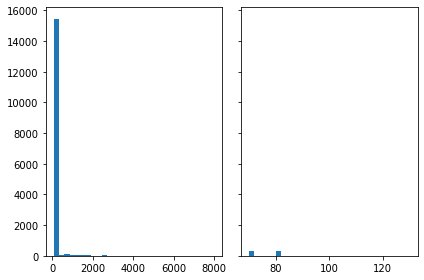

In [58]:
from matplotlib import pyplot as plt

n_bins = 30

# Generate a normal distribution, center at x=0 and y=5

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(sim.application_model.response_times_by_request['auth'], bins=n_bins)
axs[1].hist(sim.application_model.response_times_by_request['buy'], bins=n_bins)

In [61]:
import numpy as np
np.median(sim.application_model.response_times_by_request['auth'])
# TODO: probably a bug - response time of some requests (auth) is smaller than the critical path

70.0

In [38]:
class Test:
    def __init__(self):
        self.num = 0
        
rt = [Test(), Test(), Test()]
for t in rt:
    t.num += 4

for t in rt:
    print(t.num)

4
4
4


In [83]:
rt = [1, 2, 3]
rt.append(8)
rt

[1, 2, 3, 8]

In [ ]:
# TODO: consider scaling links?
class Link:
    def __init__(self,
                 simulation_step_ms,
                 latency,
                 bandwidth = 1000):
        # Static state
        self.latency = latency
        self.bandwidth = bandwidth
        self.simulation_step_ms = simulation_step_ms
        
        # Dynamic state
        self.requests = [] 
        
    def put_request(self, req):
        if len(self.requests) < self.bandwidth:
            req.processing_left_ms = self.latency
            self.requests.append(req)
            return True
        else:
            return False
        
    def get_requests(self):
        # Called every simulation step thus updating reqs
        reqs_to_give = []
        for req in self.requests:
            min_time_left = min(req.processing_left_ms, self.simulation_step_ms)
            if req.processing_left_ms - min_time_left <= 0:
                req.processing_left_ms = 0
                req.cumulative_time_ms += min_time_left
                reqs_to_give.append(req)
            else:
                req.processing_left_ms -= min_time_left
                
        return reqs_to_give

class NetworkModel:
    def __init__(self,
                 links_dict_in = None):
        self.links_dict_in = links_dict_in
        self.links_dict_out = {}
        
        # TODO: from file
        for link_start, outs in self.links_dict.items():
            for out, link in outs.items():
                if out in self.links_dict_out:
                    self.links_dict_out[out].append(link)
                else:
                    self.links_dict_out[out] = [link]
                    
    def put_request(self,
                    start_service_lbl,
                    end_service_lbl,
                    req):
        
        self.links_dict_in[start_service_lbl][end_service_lbl].put_request(req)
    
    def get_requests(self,
                     end_service_lbl):
        reqs = []
        links = self.links_dict_out[end_service_lbl]
        for link in links:
            reqs.extend(link.get_requests())
            
        return reqs